# Run Summa model on HPC

Structure for Unifying Multiple Modeling Alternative [(SUMMA)](https://ral.ucar.edu/projects/summa) is a hydrologic modeling approach that is built on a common set of conservation equations and a common numerical solver, which together constitute the structural core of the model. Different modeling approaches can then be implemented within the structural core, enabling a controlled and systematic analysis of alternative modeling options, and providing insight for future model development.

This notebook demonstrates how to harmonize different libraries and tools provided in the CyberGIS-Jupyter environment to run SUMMA model with a High Performance Computer (HPC) resource (Lyu 2019). The SUMMA Model instance used is a part of the Clark et al., (2015) study, and explored the impact of different stomatal resistance parameterizations on total evapotranspiration (ET) in the Reynolds Mountain East catchment in southwestern Idaho.

Lyu, F., Yin, D., Padmanabhan, A., Choi, Y., Goodall, J. L., Castronova, A., Tarboton, D., Wang, S. (2019) “Bridging Reproducible Hydrological Modeling with CyberGIS-Jupyter: A Case Study on SUMMA”. In: Proceedings of Practice and Experience in Advanced Research Computing (PEARC19), July 28-August 1, 2019, Chicago, IL, USA. https://dl.acm.org/citation.cfm?id=3333052

Clark, M. P., B. Nijssen, J. Lundquist, D. Kavetski, D. Rupp, R. Woods, E. Gutmann, A. Wood, D. Gochis, R. Rasmussen, D. Tarboton, V. Mahat, G. Flerchinger, and D. Marks, 2015: A unified approach for process-based hydrologic modeling: Part 2. Model implementation and example applications. Water Resources Research, 51, doi: 10.1002/2015WR017200



# Notebook Outline
- [Retrieve Resources](#resources)
- [Unzip model instance package](#unzip)
- [Install SUMMA model](#install)
- [Use PySumma to configure model parameters](#build)
- [Submit model](#submit)
- [Check model output](#check)
- [Plot](#plot)
- [Cleanup](#cleanup)

<a id='resources'></a>
## Retrieve a Summa model instance resource from HydroShare

This is the resource id of a HydroShare composite resource that contains a SUMMA model instance/. For more info on this resource please refer to https://www.hydroshare.org/resource/1f3f310af8364d2aa3e6a9459152a21c/)

In [1]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'

We use HydroShare REST API Python client (hs_restclient) to retrieve the above resource onto the notebook server

In [2]:
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
import subprocess
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = "/home/jovyan/shared_data/data/tmp_job_submit"

out = subprocess.Popen(['ls',  '/home/jovyan/shared_data/data/tmp_job_submit'], 
           stdout=subprocess.PIPE, 
           stderr=subprocess.STDOUT)
stdout,stderr = out.communicate()
if (resource_id.encode("utf-8") not in stdout):
    !mkdir -p {download_dir}
    hs.getResource(resource_id, destination=download_dir, unzip=True)

<a id='unzip'></a>
## Unzip model instance package

Create a temporary local folder and unzip the summa instance

In [3]:
import os
#Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance_sopron"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
import tempfile
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance_sopron.zip
   creating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/
   creating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/
   creating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/
  inflating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc  
  inflating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson  
   creating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/
  inflating: /home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFl

<a id='install'></a>
## "Install" SUMMA model on Jupyter server (fix broken path in summa file_manager)

By default, the file_manager file of the Summa instance does not contain local path. Need to use script to install it locally.

In [4]:
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


<a id='build'></a>
## Use PySumma to configure model parameters

We set Start and Finish points for the simulation and set Stomatal Resistance type to be 'BallBerry'

In [5]:
from pysumma import Simulation

# path to the SUMMA filemanager file on Jupyter
file_manager = os.path.join(model_source_folder_path, file_manger_rel_path)

# Create pySUMMA Simulation Object
executable = ""
S = Simulation(executable, file_manager)

# Configure the model
S.decisions['simulStart'].value = "2006-07-01 00:00"
S.decisions['simulFinsh'].value = "2007-08-20 00:00"
S.decisions['stomResist'].value = 'BallBerry'
# Save configiuration to disk
S._write_configuration()
print(S)

Executable path: 
Simulation status: Initialized
File manager configuration:
'SUMMA_FILE_MANAGER_V1.0'    ! filemanager_version
'/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/'    ! settings_path
'/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/'    ! input_path
'/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output/'    ! output_path
'summa_zDecisions_riparianAspenSimpleResistance.txt'    ! decisions_path
'meta/summa_zTimeMeta.txt'    ! meta_time
'meta/summa_zLocalAttributeMeta.txt'    ! meta_attr
'meta/summa_zCategoryMeta.txt'    ! meta_type
'meta/summa_zForceMeta.txt'    ! meta_force
'meta/summa_zLocalParamMeta.txt'    ! meta_localparam
'meta/Model_Output.txt'    ! output_control
'meta/summa_zLocalModelIndexMeta.txt'    ! meta_localindex
'meta/summa_zBasinParamMeta.txt'    ! meta_basinparam
'meta/summa_zBasinMode

<a id='submit'></a>
## Submit model to XSEDE Comet HPC using CyberGIS-Jupyter tool

We use cybergis lib to submit the model to HPC as a job

In [6]:
from cybergis import HPCUI
import json

dict_ = {}
dict_["model"] = "summa"
dict_["model_source_folder_path"] = model_source_folder_path
dict_["file_manger_rel_path"] = file_manger_rel_path
dict_["workspace_dir"] = workspace_dir
dict_["machine"] = "keeling"

para_json_str = json.dumps(dict_)

s = HPCUI(para_json_str)
s.run()

2020-04-23 23:23:22,681 [MainThread  ] [INFO ]  SSH logged into keeling.earth.illinois.edu as user cigi-gisolve
2020-04-23 23:23:22,808 [MainThread  ] [INFO ]  Uploading /home/jovyan/work/workspace/Summa_1587684196_0263e7c2 to /data/keeling/a/cigi-gisolve
2020-04-23 23:23:26,609 [MainThread  ] [INFO ]  Submitting Job summa.sbatch to queue
2020-04-23 23:23:27,054 [MainThread  ] [INFO ]  Remote Job ID assigned: 3536818
2020-04-23 23:23:30,828 [MainThread  ] [INFO ]  R
2020-04-23 23:23:34,325 [MainThread  ] [INFO ]  R
2020-04-23 23:23:37,906 [MainThread  ] [INFO ]  R
2020-04-23 23:23:41,426 [MainThread  ] [INFO ]  R
2020-04-23 23:23:44,977 [MainThread  ] [INFO ]  R
2020-04-23 23:23:48,531 [MainThread  ] [INFO ]  R
2020-04-23 23:23:52,079 [MainThread  ] [INFO ]  Job completed: Summa_1587684196_0263e7c2; 3536818
2020-04-23 23:23:52,081 [MainThread  ] [INFO ]  Downloading /data/keeling/a/cigi-gisolve/Summa_1587684196_0263e7c2/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output to 

Walltime (hour) is the maximum duration of time the job is allowed to run on the HPC before it gets killed. Nodes indicate the number of CPU cores will be allocated for this job. If multiple model runs are configured (see ensemble example), CyberGIS lib will run the job over the assigned CPUs in parallel. In this case where only a single model run is configured, we just need to assign it with 1 node and use the default Walltime (1 hour).

In [7]:
dict_ = {}
dict_["model"] = "print"
dict_["machine"] = "keeling"

para_json_str = json.dumps(dict_)

s2 = HPCUI(para_json_str)
s2.run()

Once job finishes execution on HPC, cybergis lib will retrieve the results back to notebook server. In this case there will be only one netcdf file in the output.

In [8]:
job_dir = os.path.join(workspace_dir, 
                            "{}/output".format(s.job_local_id))
summa_output = os.path.join(job_dir, 
                            "vegImpactsTranspire_output_test_timestep.nc")
print(summa_output)

/home/jovyan/work/workspace/Summa_1587684196_0263e7c2/output/vegImpactsTranspire_output_test_timestep.nc


<a id='check'></a>
## Check model output  -- NetCDF file

Use xarray to check the metadata of the nc file

In [9]:
import xarray as xr
output_info = xr.open_dataset(summa_output)
output_info

<xarray.Dataset>
Dimensions:                    (gru: 1, hru: 1, ifcSoil: 9, ifcToto: 14, midSoil: 8, midToto: 13, time: 9961)
Coordinates:
  * time                       (time) datetime64[ns] 2006-07-01 ...
  * hru                        (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    hruId                      (hru) int32 ...
    basin__SurfaceRunoff       (time, gru) float64 ...
    basin__ColumnOutflow       (time, gru) float64 ...
    basin__AquiferStorage      (time, gru) float64 ...
    basin__AquiferRecharge     (time, gru) float64 ...
    basin__AquiferBaseflow     (time, gru) float64 ...
    basin__AquiferTranspire    (time, gru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    nSnow                      (time, hru) int32 ...
    nSoil

<a id='plot'></a>
## Plot time series for total evapotranspiration

Plot Total Evapotranspiration over time

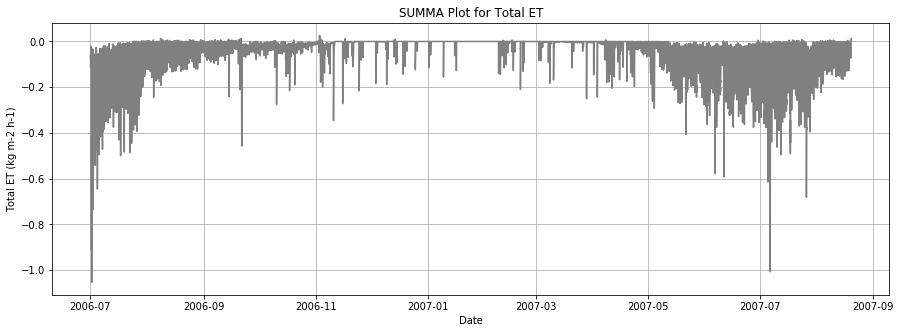

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
x = output_info['time']
y = (output_info['scalarCanopyTranspiration'] + \
     output_info['scalarCanopyEvaporation'] + \
     output_info['scalarGroundEvaporation'])*3600

plt.figure(figsize=(15, 5))
plt.plot(x, y, color='grey', linestyle='solid', markersize=0)

    # Get the current axis of the plot and
    # set the x and y-axis labels
ax = plt.gca()
ax.set_ylabel("Total ET (kg m-2 h-1)")
ax.set_xlabel('Date')
ax.grid(True)

ax.set_title('SUMMA Plot for Total ET')
output_info.close()

<a id='cleanup'></a>
## Cleanup

This step is optional, which will remove all model outputs on notebook server

In [11]:
! rm -rvf {unzip_dir} {job_dir}

removed '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc'
rm: cannot remove '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData': Directory not empty
removed '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson'
removed '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFlux.nc'
removed directory '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData'
removed '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/installTestCases_local.sh'
removed directory '/home/jovyan/work/workspace/tmppx2i7nfg/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/output'
removed '/home

## Done